<a href="https://colab.research.google.com/github/JedrzejSzpygiel/Perceptron/blob/main/deep_forest_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tree crown detection using DeepForest

## Context
### Purpose
Detect tree crown using a state-of-art Deep Learning model for object detection.

### Modelling approach
A prebuilt Deep Learning model, named *DeepForest*, is used to predict individual tree crowns from an airborne RGB image. *DeepForest* was trained on data from the National Ecological Observatory Network (NEON). _DeepForest_ was implemented in Python 3.7 using initally Tensorflow v1.14 but later moved to Pytorch. Further details can be found in the [package documentation](https://deepforest.readthedocs.io/en/latest/).

### Highlights
* Fetch and load a NEON image from a Zenodo repository using `intake` and `dask`.
* Retrieve and plot the ground-truth annotations (bounding boxes) for the target image.
* Load and use a pretrained *DeepForest* model to generate predictions from the full-image or tile-wise prediction.
* Indicate the pros and cons of full-image and tile-wise prediction.

### Contributions

#### Notebook
Alejandro Coca-Castro (author), The Alan Turing Institute, [@acocac](https://github.com/acocac)
Matt Allen (reviewer), Department of Geography - University of Cambridge, [@mja2106](https://github.com/mja2106), 21/09/21 (latest revision)

#### Modelling codebase
- Ben Weinstein (maintainer & developer), University of Florida, [@bw4sz](https://github.com/bw4sz)
- Henry Senyondo (support maintainer), University of Florida, [@ethanwhite](https://github.com/ethanwhite)
- Ethan White (PI and author), University of Florida, [@weecology](https://github.com/henrykironde)
- Other contributors are listed in the [GitHub repo](https://github.com/weecology/DeepForest/graphs/contributors)


## Install and load libraries

In [2]:
!pip -q install git+https://github.com/ESM-VFC/intake_zenodo_fetcher.git ##Intake Zenodo Fetcher
!pip -q install pycurl
!pip -q install DeepForest
!pip -q install intake
!pip install intake-xarray
!pip -q install hvplot
!pip install intake-xarray
!pip install xr

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.2/234.2 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [24]:
import glob
import os
import urllib
import numpy as np
import intake
from intake_zenodo_fetcher import download_zenodo_files_for_entry
import matplotlib.pyplot as plt
import xmltodict
import cv2
from deepforest import main
import xarray as xr
from PIL import Image
import tempfile
from deepforest import preprocess
import torch

%matplotlib inline

## Fetch a RGB image from Zenodo
Fetch a sample image from a publically accessible location.

In [4]:
# create a temp dir
path = tempfile.mkdtemp()

catalog_file = os.path.join(path, 'catalog.yaml')

with open(catalog_file, 'w') as f:
    f.write('''
sources:
  NEONTREE_rgb:
    driver: xarray_image
    description: 'NeonTreeEvaluation RGB images (collection)'
    metadata:
      zenodo_doi: "10.5281/zenodo.3459803"
    args:
      urlpath: "{{ CATALOG_DIR }}/NEONsample_RGB/2018_MLBS_3_541000_4140000_image_crop.tif"
      ''')

Load an intake catalog for the downloaded data.

In [5]:
cat_tc = intake.open_catalog(catalog_file)

In [6]:

for catalog_entry in list(cat_tc):
    download_zenodo_files_for_entry(
        cat_tc[catalog_entry],
        force_download=False
    )

will download https://zenodo.org/api/files/5b372ed9-e4ec-41b0-a652-f0ce7d760e60/2018_MLBS_3_541000_4140000_image_crop.tif to /tmp/tmprfpn6z2j/NEONsample_RGB/2018_MLBS_3_541000_4140000_image_crop.tif


  0%|          | 0.00/100 [00:00<?, ?B/s]

## Load sample image

Here we use `intake` to load the image through `dask`.

In [7]:
tc_rgb = cat_tc["NEONTREE_rgb"].to_dask()

/usr/local/lib/python3.9/dist-packages/xarray/core/dataarray.py:1302: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


In [8]:
tc_rgb

<xarray.DataArray (y: 1864, x: 1429, channel: 3)>
dask.array<xarray-<this-array>, shape=(1864, 1429, 3), dtype=uint8, chunksize=(1864, 1429, 3), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1857 1858 1859 1860 1861 1862 1863
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1422 1423 1424 1425 1426 1427 1428
  * channel  (channel) int64 0 1 2

## Load and prepare labels

In [9]:
filenames = glob.glob(os.path.join(path, './NEONsample_RGB/*.tif'))
filesn = [os.path.basename(i) for i in filenames]

In [10]:
##Create ordered dictionary of .xml annotation files
def loadxml(imagename):
  imagename = imagename.replace('.tif','')
  fullurl = "https://raw.githubusercontent.com/weecology/NeonTreeEvaluation/master/annotations/" + imagename + ".xml"
  file = urllib.request.urlopen(fullurl)
  data = file.read()
  file.close()
  data = xmltodict.parse(data)
  return data

allxml = [loadxml(i) for i in filesn]

In [11]:
# function to extract bounding boxes
def extractbb(i):
  bb = [f['bndbox'] for f in allxml[i]['annotation']['object']]
  return bb

bball = [extractbb(i) for i in range(0,len(allxml))]
print(len(bball))

1


## Visualise image and labels

In [12]:
# function to plot images
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

In [13]:
image = tc_rgb

In [14]:
# plot predicted bbox
image2 = image.values.copy()
target_bbox = bball[0]
print(type(target_bbox))
print(target_bbox[0:2])

<class 'list'>
[{'xmin': '1377', 'ymin': '697', 'xmax': '1429', 'ymax': '752'}, {'xmin': '787', 'ymin': '232', 'xmax': '811', 'ymax': '256'}]


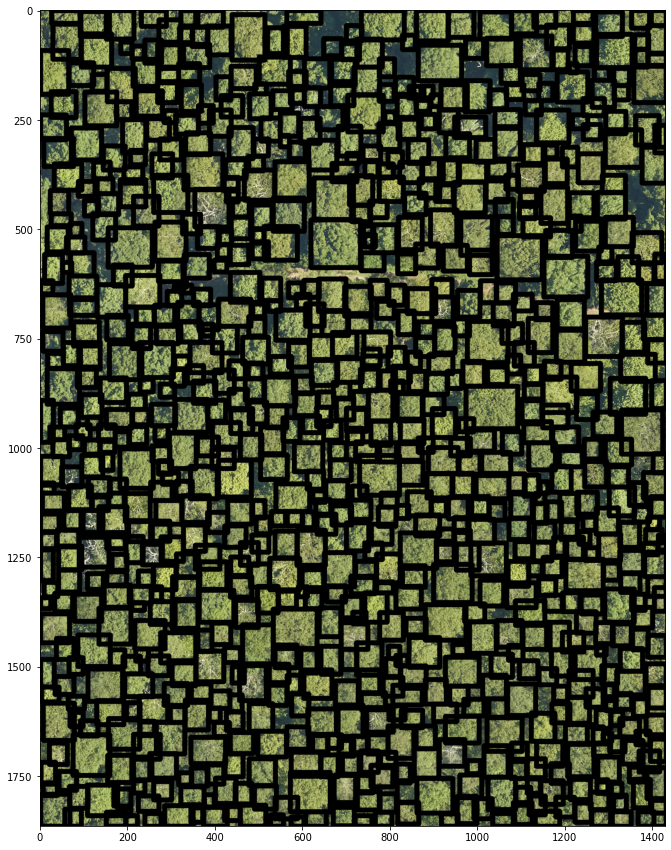

In [15]:
for row in target_bbox:
    cv2.rectangle(image2, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=10, lineType=cv2.LINE_AA)

plt.figure(figsize=(15,15))
cv2_imshow(np.flip(image2,2))
plt.show()

## Load *DeepForest* pretrained model

Now we're going to load and use a pretrained model from the `deepforest` package.

In [17]:
path = 'path with image'
image_test = Image.open(path)
image_test = np.array(image_test)
image_test = image_test[:,:,0:3]
data_xr = xr.DataArray(image_test)
image = data_xr

In [18]:
# load deep forest model
model = main.deepforest()
model.use_release()
model.current_device = torch.device("cpu")

Reading config file: /usr/local/lib/python3.9/dist-packages/deepforest/data/deepforest_config.yml


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

NEON.pt: 129MB [00:01, 84.1MB/s]                          


Model was downloaded and saved to /usr/local/lib/python3.9/dist-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [20]:
pred_boxes = model.predict_image(image=image.values)


/usr/local/lib/python3.9/dist-packages/deepforest/predict.py:34: UserWarning: Image type is uint8, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn(f"Image type is {image.dtype}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')")


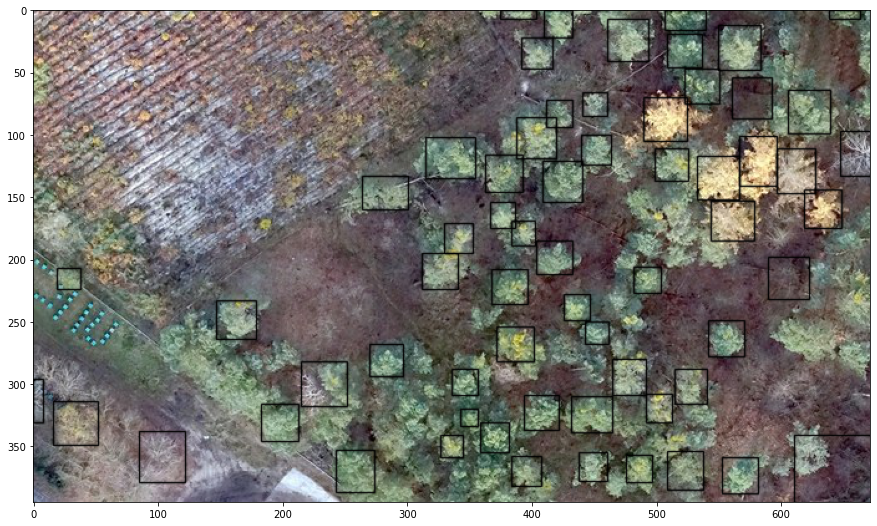

In [21]:
image3 = image.values.copy()

for index, row in pred_boxes.iterrows():
    cv2.rectangle(image3, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)

plt.figure(figsize=(15,15))
cv2_imshow(np.flip(image3,2))
plt.show()



## Tile-based prediction
To optimise the predictions, the DeepForest can be run [tile-wise](https://deepforest.readthedocs.io/en/latest/better.html).

The following cells show how to define the optimal window i.e. tile size.

In [25]:
#Create windows of 400px
windows = preprocess.compute_windows(image.values, patch_size=400,patch_overlap=0)
print(f'We have {len(windows)} in the image')

We have 2 in the image


/usr/local/lib/python3.9/dist-packages/deepforest/predict.py:34: UserWarning: Image type is uint8, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn(f"Image type is {image.dtype}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')")
/usr/local/lib/python3.9/dist-packages/deepforest/predict.py:34: UserWarning: Image type is uint8, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn(f"Image type is {image.dtype}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')")


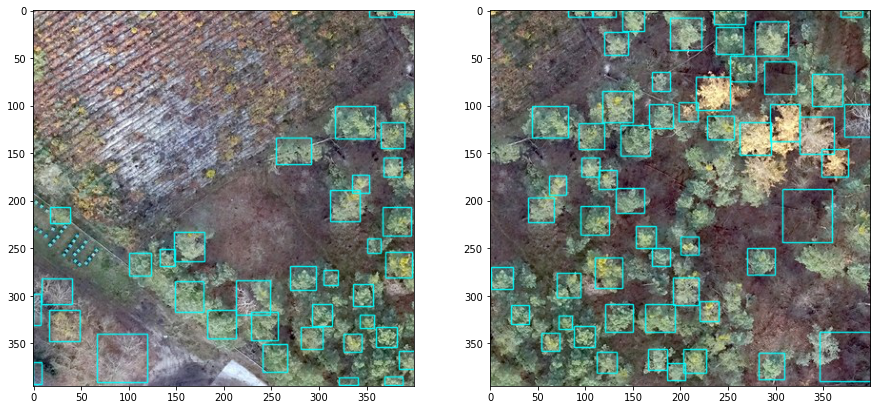

In [26]:
#Loop through a few sample windows, crop and predict
fig, axes, = plt.subplots(nrows=len(windows)//2,ncols=2, figsize=(15,15))
axes = axes.flatten()
for index2 in range(len(windows)):
    crop = image.values[windows[index2].indices()]
    #predict in bgr channel order, color predictions in red.
    boxes = model.predict_image(image=np.flip(crop[...,::-1],2), return_plot = True)

    #but plot in rgb channel order
    axes[index2].imshow(boxes[...,::-1])

Once a suitable tile size is defined, we can run in a batch using the `predict_tile` function:

100%|██████████| 2/2 [00:12<00:00,  6.13s/it]


90 predictions in overlapping windows, applying non-max supression
74 predictions kept after non-max suppression


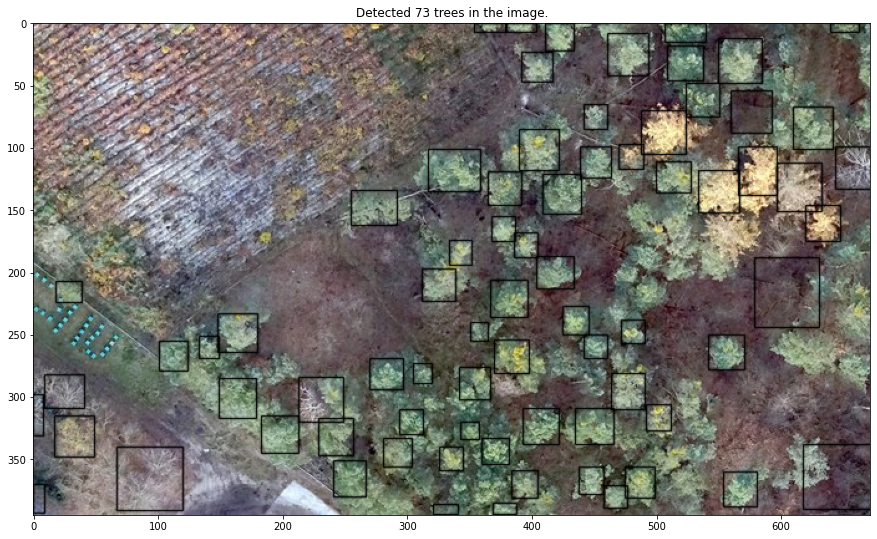

In [30]:
tile = model.predict_tile(image=image.values,return_plot=False,patch_overlap=0.2,iou_threshold=0.05,patch_size=400)

# plot predicted bbox
image_tile = image.values.copy()

for index, row in tile.iterrows():
    cv2.rectangle(image_tile, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
title = "Detected "+str(index)+" trees in the image."
fig = plt.figure(figsize=(15,15))
plt.title(title)
ax2 = plt.subplot(1, 1, 1), cv2_imshow(np.flip(image_tile,2))
plt.show() # To show figure




**Interpretation**
* The tile-based prediction provides more reasonable results than predicting over the whole image.
* While the prediction looks closer to the ground truth labels, there seem to be some tiles edges artefacts. This will require further investigation i.e. inspecting the `deepforest` tile-wise prediction function to understand how the predictions from different tiles are combined after the model has made them.